<a href="https://colab.research.google.com/github/QaziSaim/AI-Voice-Assistant/blob/main/Iterative_Workflow_langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install langgraph
!pip install langchain_groq

In [ ]:
from langchain_groq import ChatGroq
from google.colab import userdata
import os
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

In [ ]:
generator_llm = ChatGroq(model='openai/gpt-oss-120b')
evaluator_llm = ChatGroq(model='meta-llama/llama-4-scout-17b-16e-instruct')
optimizer_llm = ChatGroq(model='openai/gpt-oss-20b')

In [ ]:
generator_llm.invoke('Who are you?').content

'I’m ChatGPT, an AI language model created by OpenAI. I’m designed to understand and generate text, answer questions, help with writing, and chat about a wide range of topics. Feel free to ask me anything!'

In [ ]:
evaluator_llm.invoke('Who are you?').content

"I'm an AI assistant designed by Meta. I'm here to answer your questions, share interesting ideas and maybe even surprise you with a fresh perspective. What's on your mind?"

In [ ]:
from langgraph.graph import StateGraph,START, END

In [ ]:
from typing import Annotated, TypedDict, Literal
from langchain_core.messages import SystemMessage, HumanMessage

In [ ]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")


In [ ]:
structure_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [ ]:
import operator

In [ ]:
class TweetState(TypedDict):
  topic: str
  tweet: str
  evaluation: Literal["approved","needs_imporvement"]
  feedback:str
  iteration: int
  max_iteration: int

  tweet_history: Annotated[list[str], operator.add]
  feedback_history: Annotated[list[str], operator.add]


In [ ]:
def generate_tweet(state:TweetState):

  # prompt
  messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
  ]

  # send generator_llm
  response = generator_llm.invoke(messages).content
  # return response
  return {'tweet':response,'tweet_history': [response]}

In [ ]:
def evaluate_tweet(state:TweetState):

  # prompt
  messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?
2. Humor – Did it genuinely make you smile, laugh, or chuckle?
3. Punchiness – Is it short, sharp, and scroll-stopping?
4. Virality Potential – Would people retweet or share it?
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"
- feedback: One paragraph explaining the strengths and weaknesses
""")
]
  #
  response = structure_evaluator_llm.invoke(messages)
  return {'evaluation':response.evaluation,'feedback':response.feedback,'feedback_history': [response.feedback]}

In [ ]:
def optimize_tweet(state: TweetState):
  messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
  response = optimizer_llm.invoke(messages).content
  iteration = state['iteration'] + 1
  return {'tweet':response,'iteration':iteration,'tweet_history':[response]}

In [ ]:
def route_evaluation(state:TweetEvaluation):

  if state['evaluation'] == 'approved' or state['iteration']>=state['max_iteration']:
    return 'approved'
  else:
    return 'needs_imporvement'

def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [ ]:
graph = StateGraph(TweetState)

graph.add_node('generate',generate_tweet)
graph.add_node('evaluate',evaluate_tweet)
graph.add_node('optimize',optimize_tweet)

graph.add_edge(START,'generate')
graph.add_edge('generate','evaluate')

graph.add_conditional_edges('evaluate',route_evaluation, {'approved':END,'needs_imporvement':'optimize'})
graph.add_edge('optimize','evaluate')

workflow = graph.compile()

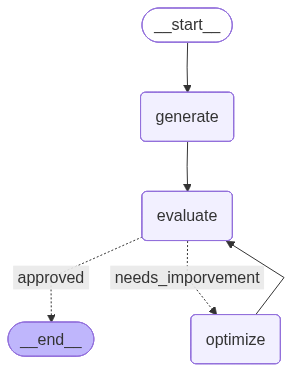

In [ ]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())


In [ ]:
initial_state = {
    "topic": "Indian Railways",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)


In [ ]:
for tweet in result['tweet_history']:
    print(tweet)

Indian Railways: you board in Delhi, meet three strangers, lose your luggage, discover a new religion, get a free chai at 3 am, and still arrive “on time” for dinner. All in one ticket. 🚂☕ #IRL #RailwayChronicles


In [ ]:
workflow.invoke(initial_state)

{'topic': 'Indian Railways',
 'tweet': 'Indian Railways: where the only thing faster than the train is the rumor that it’s actually on time. Seats? Optional. Snacks? Free—if you count the guy who shares his chapati. #DesiTravel',
 'evaluation': 'approved',
 'feedback': "The tweet excels in originality with its unique take on the Indian Railways experience, humorously highlighting the contrast between the speed of rumors and the actual train. The punchiness is well-achieved, being short, sharp, and engaging. Its virality potential is high due to its relatability and humor. The format is well-suited for Twitter, under 280 characters and effectively using a hashtag. The only area for improvement could be in adding more specificity to avoid any potential generic feel, but overall, it's a strong, well-crafted tweet.",
 'iteration': 1,
 'max_iteration': 5,
 'tweet_history': ['Indian Railways: where the only thing faster than the train is the rumor that it’s actually on time. Seats? Optional.